# Librerías necesarias

In [1]:
import pandas as pd
import math
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import nearest_points
import descartes
import numpy as np
from pyproj import Proj, transform
import scipy
from scipy.spatial import cKDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import seaborn as sn
import pysal as ps
from sklearn import cluster
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import libpysal as lp
from dbfread import DBF
%matplotlib inline

c:\programdata\miniconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
c:\programdata\miniconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Importación de archivos

In [2]:
#Asignación de localidad a terreno
cobertura = gpd.read_file('conjunto_de_datos/Cobertura/cobertura.shp')
terrenos = gpd.read_file('conjunto_de_datos/Terrenos/terrenos.shp')
terrenos.head()

,Title,Address,Descripcio,Precio,TamaÃ±o,Latitud,Longitud,Tamano,Precio/Tam,geometry
0,LagunasInterior . Punta TiburÃ³n Residencial; ...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,769500.0,180 mÂ²,19.067293,-96.080747,180.0,4275.000000,POINT (-96.08075 19.06729)
1,La Escondida Residencial â Terrenos,Octava Avenida y Veracruz||RincÃ³n de La Sierr...,La Escondida ResidencialResidencias y Lotes de...,711000.0,140 mÂ²,25.641346,-100.198342,140.0,5078.571429,POINT (-100.19834 25.64135)
2,El Molino Residencial & Golf,Paseos El Molino # 302; LeÃ³n; Gto||Balcones d...,El Molino; Residencial & GolfEs un impresionan...,845719.0,250 mÂ²,21.185639,-101.699237,250.0,3382.876000,POINT (-101.69924 21.18564)
3,Club Cenote Residencial,Ruta de los Cenotes Km 19 DesviaciÃ³n Delirios...,Club Cenote ResidencialAmplios Terrenos en el ...,1039000.0,800 mÂ²,20.847873,-87.220608,800.0,1298.750000,POINT (-87.22061 20.84787)
4,Punta TiburÃ³n Residencial; Marina & Golf - Bo...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,723672.0,180 mÂ²,19.067293,-96.080747,180.0,4020.400000,POINT (-96.08075 19.06729)


In [3]:
cobertura.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1.0,SI,010010001,POINT (-102.29611 21.88083)
1,10010094,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita,1022225,215219,1903,14,Localidad Menor,g)<500,14,0,1.0,SI,010010094,POINT (-102.37361 21.87194)
2,10010096,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,1022127,215303,1863,37,Localidad Menor,g)<500,37,0,1.0,SI,010010096,POINT (-102.35750 21.88417)
3,10010100,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre,1022222,215116,1880,10,Localidad Menor,g)<500,10,0,1.0,SI,010010100,POINT (-102.37278 21.85444)
4,10010102,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho],1022126,214649,1860,7,Localidad Menor,g)<500,7,0,1.0,SI,010010102,POINT (-102.35722 21.78028)


# Asignación de localidad a cada terreno

In [4]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns == 'Clave'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

terrenos_loc = ckdnearest(terrenos, cobertura)

In [5]:
terrenos_loc.head()

,Title,Address,Descripcio,Precio,TamaÃ±o,Latitud,Longitud,Tamano,Precio/Tam,geometry,Clave,dist
0,LagunasInterior . Punta TiburÃ³n Residencial; ...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,769500.0,180 mÂ²,19.067293,-96.080747,180.0,4275.000000,POINT (-96.08075 19.06729),300110292,0.002173
1,La Escondida Residencial â Terrenos,Octava Avenida y Veracruz||RincÃ³n de La Sierr...,La Escondida ResidencialResidencias y Lotes de...,711000.0,140 mÂ²,25.641346,-100.198342,140.0,5078.571429,POINT (-100.19834 25.64135),190310045,0.015914
2,El Molino Residencial & Golf,Paseos El Molino # 302; LeÃ³n; Gto||Balcones d...,El Molino; Residencial & GolfEs un impresionan...,845719.0,250 mÂ²,21.185639,-101.699237,250.0,3382.876000,POINT (-101.69924 21.18564),110201198,0.001994
3,Club Cenote Residencial,Ruta de los Cenotes Km 19 DesviaciÃ³n Delirios...,Club Cenote ResidencialAmplios Terrenos en el ...,1039000.0,800 mÂ²,20.847873,-87.220608,800.0,1298.750000,POINT (-87.22061 20.84787),230070078,0.000190
4,Punta TiburÃ³n Residencial; Marina & Golf - Bo...,Km. 4.5 Carretera Federal Boca del RÃ­o - AntÃ...,Punta tiburÃ³n residencial se encuentra en la ...,723672.0,180 mÂ²,19.067293,-96.080747,180.0,4020.400000,POINT (-96.08075 19.06729),300110292,0.002173


# Cálculo de precio promedio de m$^2$ para cada localidad con terrenos publicados

In [6]:
locs_ter =terrenos_loc.groupby('Clave').mean().reset_index()
locs_ter.head()

,Clave,Precio,Latitud,Longitud,Tamano,Precio/Tam,dist
0,010010001,6213848.8,21.886016,-102.294572,881.6,6099.877565,0.008725
1,010010106,39250000.0,21.798480,-102.276770,34000.0,821.551724,0.003309
2,010010120,223672100.0,21.715990,-102.306005,446122.0,527.472577,0.013063
3,010010126,1800000.0,22.014230,-102.192930,10000.0,180.000000,0.008240
4,010010135,13993800.0,21.699490,-102.311850,5961.5,6341.248721,0.001018


In [7]:
cobertura = pd.merge(cobertura,locs_ter[['Precio/Tam','Clave']],how='left', on='Clave')

In [8]:
cobertura.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry,Precio/Tam
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1.0,SI,010010001,POINT (-102.29611 21.88083),6099.877565
1,10010094,1,Aguascalientes,1,Aguascalientes,94,Granja Adelita,1022225,215219,1903,14,Localidad Menor,g)<500,14,0,1.0,SI,010010094,POINT (-102.37361 21.87194),NaN
2,10010096,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,1022127,215303,1863,37,Localidad Menor,g)<500,37,0,1.0,SI,010010096,POINT (-102.35750 21.88417),NaN
3,10010100,1,Aguascalientes,1,Aguascalientes,100,Rancho Alegre,1022222,215116,1880,10,Localidad Menor,g)<500,10,0,1.0,SI,010010100,POINT (-102.37278 21.85444),NaN
4,10010102,1,Aguascalientes,1,Aguascalientes,102,Los Arbolitos [Rancho],1022126,214649,1860,7,Localidad Menor,g)<500,7,0,1.0,SI,010010102,POINT (-102.35722 21.78028),NaN


In [9]:
cob_precio = cobertura[(~cobertura['Precio/Tam'].isna())]
cob_precio['% COB OPER'] = cob_precio['% COB OPER'].astype(int)

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
cob_precio.head()

,ID,ID ENTIDAD,ENTIDAD,ID MUNICIP,MUNICIPIO,ID LOCALID,LOCALIDAD,longitud,latitud,altitud,Población,Clasificac,Rango,HAB_CUB_OP,HAB_SCOB_O,% COB OPER,COB OPERAD,Clave,geometry,Precio/Tam
0,10010001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1021746,215251,1885,722250,Localidad Mayor,a) > 10 mil,722250,0,1,SI,010010001,POINT (-102.29611 21.88083),6099.877565
6,10010106,1,Aguascalientes,1,Aguascalientes,106,Arellano,1021628,214803,1894,1382,Localidad Menor,"e)>1,000",1382,0,1,SI,010010106,POINT (-102.27444 21.80083),821.551724
9,10010120,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Peñuelas,1021744,214303,1870,935,Localidad Menor,f)>500,935,0,1,SI,010010120,POINT (-102.29556 21.71750),527.472577
12,10010126,1,Aguascalientes,1,Aguascalientes,126,Cañada Honda [Estación],1021153,220028,1927,509,Localidad Menor,f)>500,509,0,1,SI,010010126,POINT (-102.19806 22.00778),180.000000
15,10010135,1,Aguascalientes,1,Aguascalientes,135,El Cedazo (Cedazo de San Antonio),1021839,214158,1859,234,Localidad Menor,g)<500,234,0,1,SI,010010135,POINT (-102.31083 21.69944),6341.248721


# Precios por localidad

In [11]:
estados = 'conjunto_de_datos/Estados/estados.shp'
mex = gpd.read_file(estados)
#mex

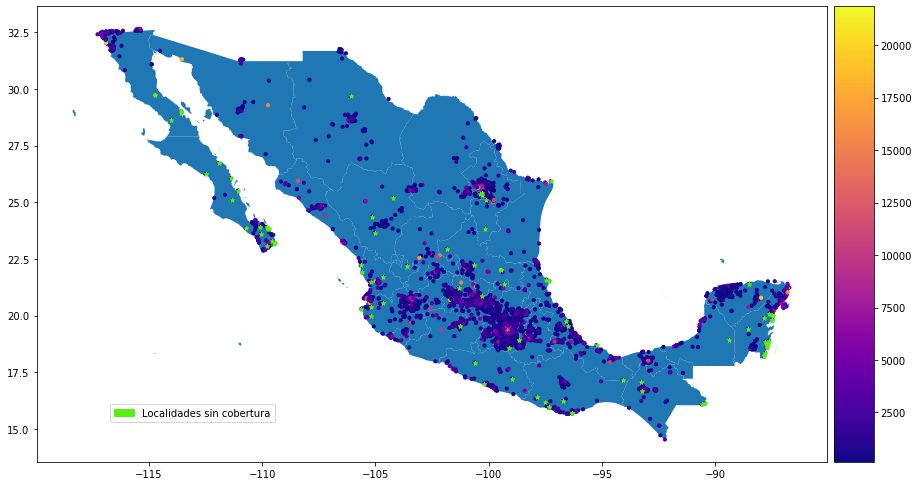

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex.plot(ax=ax)
cob_precio.plot(ax=ax,markersize=10,column='Precio/Tam', legend=True,cax=cax, cmap='plasma')
cob_precio[cob_precio['COB OPERAD']=='NO'].plot(ax=ax, markersize=20, color='#58F011',marker='*',legend=True)
red_patch = mpatches.Patch(color='#58F011', label='Localidades sin cobertura')
plt.legend(handles=[red_patch],bbox_to_anchor=(.35, .35),bbox_transform=plt.gcf().transFigure)
#plt.scatter(cob_precio.geometry.x,cob_precio.geometry.y,c=cob_precio['COB OPERAD']=='SI', cmap = cm.RdYlGn)
plt.show()

# Adjuntar variables ITER (2010)

In [13]:
def zeros(val,tipo):
    add = ''
    if tipo=='ENT':
        if val//10==0:
            add='0'
    if tipo == 'MUN':
        if val//100==0:
            if val//10==0:
                add='00'
            else:
                add='0'
    if tipo == 'LOC':
        if val//1000==0:
            if val//100==0:
                if val//10==0:
                    add = '000'
                else:
                    add = '00'
            else:
                add = '0'
    return add + str(val)

In [14]:
def nanfill(row,col,nB):
    if math.isnan(row[col]):
        nA = np.array([row['geometry'].x, row['geometry'].y])
        btree = cKDTree(nB)
        dist, idx = btree.query(nA, k=11)
        nearest = cob_precio.iloc[idx[1:]]
        disp = nearest[nearest[col].notnull()]
        prom = disp[col].head(3).mean()
        return prom
    else:
        return row[col]

In [15]:
cob_precio = cob_precio[['Clave', 'Población', '% COB OPER', 'geometry', 'Precio/Tam']]
cob_precio = cob_precio.set_index('Clave')
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_rur_caracteristicas_economicas.dbf', encoding='unicode_escape')
frame = pd.DataFrame(iter(dbf))
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_urb_caracteristicas_economicas.dbf', encoding='unicode_escape')
frame2 = pd.DataFrame(iter(dbf))
frame3 = pd.concat([frame[['CVEGEO', 'ECO1', 'ECO4']], frame2[['CVEGEO', 'ECO1', 'ECO4']]], ignore_index=True)
cob_precio = pd.merge(cob_precio.reset_index(),frame3,how='left', left_on='Clave', right_on='CVEGEO').drop('CVEGEO',axis=1)
cob_precio = cob_precio.set_index('Clave')
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_rur_servicios_de_salud.dbf', encoding='unicode_escape')
frame = pd.DataFrame(iter(dbf))
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_urb_servicios_de_salud.dbf', encoding='unicode_escape')
frame2 = pd.DataFrame(iter(dbf))
frame3 = pd.concat([frame[['CVEGEO', 'SALUD1']], frame2[['CVEGEO', 'SALUD1']]], ignore_index=True)
cob_precio = pd.merge(cob_precio.reset_index(),frame3,how='left', left_on='Clave', right_on='CVEGEO').drop('CVEGEO',axis=1)
cob_precio = cob_precio.set_index('Clave')
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_rur_viviendas.dbf', encoding='unicode_escape')
frame = pd.DataFrame(iter(dbf))
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_urb_viviendas.dbf', encoding='unicode_escape')
frame2 = pd.DataFrame(iter(dbf))
frame3 = pd.concat([frame[['CVEGEO', 'VIV2', 'VIV27', 'VIV28', 'VIV31',
                          'VIV32','VIV33', 'VIV34', 'VIV35', 'VIV36']], 
                    frame2[['CVEGEO','VIV2', 'VIV27', 'VIV28',
                          'VIV31','VIV32','VIV33', 'VIV34', 'VIV35', 'VIV36']]], ignore_index=True)
cob_precio = pd.merge(cob_precio.reset_index(),frame3,how='left', left_on='Clave', right_on='CVEGEO').drop('CVEGEO',axis=1)
cob_precio = cob_precio.set_index('Clave')
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_rur_migracion.dbf', encoding='unicode_escape')
frame = pd.DataFrame(iter(dbf))
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_urb_migracion.dbf', encoding='unicode_escape')
frame2 = pd.DataFrame(iter(dbf))
frame3 = pd.concat([frame[['CVEGEO', 'MIG1_R']], frame2[['CVEGEO', 'MIG1_R']]], ignore_index=True)
cob_precio = pd.merge(cob_precio.reset_index(),frame3,how='left', left_on='Clave', right_on='CVEGEO').drop('CVEGEO',axis=1)
cob_precio = cob_precio.set_index('Clave')
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_rur_caracteristicas_educativas.dbf', encoding='unicode_escape')
frame = pd.DataFrame(iter(dbf))
dbf = DBF('conjunto_de_datos/SCINCE/cpv2010_loc_urb_caracteristicas_educativas.dbf', encoding='unicode_escape')
frame2 = pd.DataFrame(iter(dbf))
frame3 = pd.concat([frame[['CVEGEO', 'EDU37_R', 'EDU49_R']], frame2[['CVEGEO', 'EDU37_R', 'EDU49_R']]], ignore_index=True)
cob_precio = pd.merge(cob_precio.reset_index(),frame3,how='left', left_on='Clave', right_on='CVEGEO').drop('CVEGEO',axis=1)
cob_precio = cob_precio.set_index('Clave')
df = pd.read_csv('conjunto_de_datos/SCINCE/basecompleta.csv', encoding='unicode_escape')
df['Clave']=df.apply(lambda x: zeros(x['ENT'],'ENT') + zeros(x['MUN'],'MUN') + zeros(x['LOC'], 'LOC'),axis=1)
cob_precio = pd.merge(cob_precio.reset_index(),df[['Clave','IM_2010']],how='left',on='Clave')
cob_precio = cob_precio.set_index('Clave')
cob_precio=cob_precio.replace(-6,np.nan)
cob_precio=cob_precio.replace(-9,np.nan)
cob_precio['Empleo'] = cob_precio['ECO4']/cob_precio['ECO1']
cob_precio['Salud'] = cob_precio['SALUD1']/cob_precio['Población']
cob_precio['Lavadora'] = cob_precio['VIV27']/cob_precio['VIV2']
cob_precio['Auto'] = cob_precio['VIV28']/cob_precio['VIV2']
cob_precio['Radio'] = cob_precio['VIV31']/cob_precio['VIV2']
cob_precio['Tele'] = cob_precio['VIV32']/cob_precio['VIV2']
cob_precio['Compu'] = cob_precio['VIV33']/cob_precio['VIV2']
cob_precio['Telefono'] = cob_precio['VIV34']/cob_precio['VIV2']
cob_precio['Celular'] = cob_precio['VIV35']/cob_precio['VIV2']
cob_precio['Internet'] = cob_precio['VIV36']/cob_precio['VIV2']
nB = np.array(list(zip(cob_precio.geometry.x, cob_precio.geometry.y)) )
cob_precio = cob_precio[['Población', '% COB OPER', 'Precio/Tam', 'geometry', 'Empleo',
                   'Salud', 'VIV2', 'MIG1_R','EDU37_R', 'EDU49_R', 'IM_2010', 'Lavadora', 'Auto',
                   'Radio', 'Tele', 'Compu', 'Telefono', 'Celular', 'Internet']]

In [16]:
for col in cob_precio.columns:
    if col != 'geometry':
        #print(col)
        cob_precio[col] = cob_precio.apply(lambda x: nanfill(x, col, nB),axis=1)

In [17]:
for col in cob_precio.columns:
    if col != 'geometry':
        #print(col)
        cob_precio[col] = cob_precio.apply(lambda x: nanfill(x, col, nB),axis=1)
#cob_precio[cob_precio.isnull().values]

# Análisis exploratorio general

In [18]:
cob_precio.head()

,Población,% COB OPER,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
Clave,,,,,,,,,,,,,,,,,,,
010010001,722250,1,6099.877565,POINT (-102.29611 21.88083),0.937929,0.772303,184123,74.5,23.6,10.0,-1.468581,0.855988,0.620688,0.911782,0.983375,0.424211,0.566453,0.796663,0.298730
010010106,1382,1,821.551724,POINT (-102.27444 21.80083),0.918812,0.802460,255,79.5,36.4,7.0,-1.102892,0.815686,0.529412,0.858824,0.980392,0.145098,0.333333,0.745098,0.090196
010010120,935,1,527.472577,POINT (-102.29556 21.71750),0.955182,0.760428,217,87.2,39.2,6.5,-1.041144,0.783410,0.493088,0.820276,0.976959,0.064516,0.276498,0.599078,0.055839
010010126,509,1,180.000000,POINT (-102.19806 22.00778),0.920213,0.760314,123,88.2,32.3,8.7,-1.214816,0.747967,0.487805,0.894309,0.943089,0.308943,0.349593,0.471545,0.130081
010010135,234,1,6341.248721,POINT (-102.31083 21.69944),0.908046,0.841880,47,90.2,39.9,6.9,-0.833872,0.723404,0.574468,0.787234,0.914894,0.085106,0.000000,0.723404,0.055839


In [19]:
cob_precio.describe()

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
count,4.654000e+03,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,1.400895e+04,0.980447,2351.463320,0.957383,0.630074,3605.918350,78.211843,23.582864,7.975383,-0.852395,0.628147,0.474706,0.787532,0.920540,0.225858,0.287417,0.678840,0.149980
std,8.924953e+04,0.138473,2609.072223,0.043033,0.165304,23012.745954,20.572271,8.568447,2.153203,0.575738,0.205751,0.219204,0.131207,0.111625,0.205359,0.228088,0.199495,0.190789
min,1.000000e+00,0.000000,149.811015,0.500000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-1.818301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+00,1.000000,666.666667,0.944190,0.540257,2.000000,68.025000,19.100000,6.600000,-1.232724,0.515106,0.323399,0.730613,0.906484,0.083333,0.096084,0.571429,0.016771
50%,1.330000e+02,1.000000,1479.560269,0.964870,0.650520,33.000000,85.166667,23.700000,7.700000,-0.967215,0.660965,0.456088,0.807311,0.953125,0.179775,0.262363,0.706783,0.089947
75%,1.678000e+03,1.000000,3169.346421,0.985101,0.740741,399.250000,93.700000,28.600000,9.000000,-0.616609,0.770323,0.609743,0.869606,0.976851,0.299591,0.431652,0.812795,0.197055
max,1.815786e+06,1.000000,21850.000000,1.000000,2.006423,453752.000000,100.000000,75.000000,16.500000,3.092976,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
cob_scaled = pd.DataFrame(scale(cob_precio.drop('geometry', axis=1)),columns=cob_precio.drop('geometry', axis=1).columns, index=cob_precio.drop('geometry', axis=1).index)
corrMatrix = cob_scaled.corr()

In [21]:
corrMatrix

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
Población,1.000000,0.018527,0.186231,-0.014358,0.028384,0.998373,-0.035518,-0.019525,0.129214,-0.135509,0.102187,0.021861,0.078246,0.069985,0.129800,0.184883,0.066809,0.124490
% COB OPER,0.018527,1.000000,0.018189,-0.055501,0.024980,0.018783,-0.005232,0.046411,0.096318,-0.113251,0.076074,0.017569,0.186103,0.248081,0.062586,0.090832,0.175826,0.045953
Precio/Tam,0.186231,0.018189,1.000000,0.013246,-0.045936,0.189727,-0.186219,-0.084881,0.215097,-0.103655,0.112345,0.140948,0.107134,0.057223,0.264681,0.229625,0.184834,0.273503
Empleo,-0.014358,-0.055501,0.013246,1.000000,-0.001047,-0.014087,-0.074045,-0.108733,0.116613,-0.064129,0.090842,0.073316,-0.030891,-0.026506,0.112211,0.036737,0.094401,0.112344
Salud,0.028384,0.024980,-0.045936,-0.001047,1.000000,0.031253,0.052083,0.059579,0.130384,-0.246785,0.248717,0.108224,0.031765,0.175449,0.071051,0.022118,0.091063,0.064232
VIV2,0.998373,0.018783,0.189727,-0.014087,0.031253,1.000000,-0.037148,-0.021923,0.132248,-0.137111,0.103818,0.023497,0.078096,0.070077,0.133045,0.186730,0.069197,0.128024
MIG1_R,-0.035518,-0.005232,-0.186219,-0.074045,0.052083,-0.037148,1.000000,0.088301,-0.438349,0.270670,-0.224837,-0.339608,-0.064150,-0.029989,-0.441705,-0.267130,-0.410136,-0.439720
EDU37_R,-0.019525,0.046411,-0.084881,-0.108733,0.059579,-0.021923,0.088301,1.000000,-0.152455,-0.054737,-0.072297,-0.162092,-0.011419,0.091376,-0.298414,-0.239079,-0.039918,-0.323977
EDU49_R,0.129214,0.096318,0.215097,0.116613,0.130384,0.132248,-0.438349,-0.152455,1.000000,-0.721059,0.516162,0.564296,0.367349,0.339837,0.826358,0.652482,0.541827,0.769097
IM_2010,-0.135509,-0.113251,-0.103655,-0.064129,-0.246785,-0.137111,0.270670,-0.054737,-0.721059,1.000000,-0.706260,-0.512335,-0.404647,-0.594615,-0.586032,-0.564961,-0.479698,-0.508541


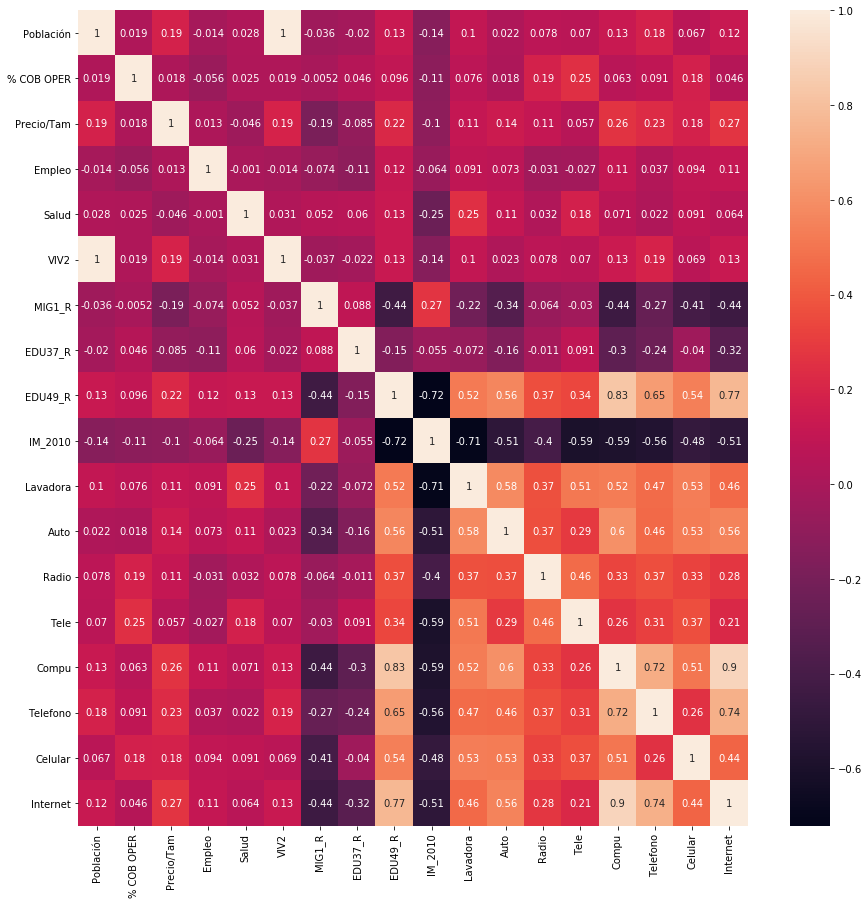

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)

In [23]:
cob_precio.groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91
1,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563


In [24]:
precio_por_cober = cob_precio.groupby('% COB OPER').mean()
precio_por_cober

,Población,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,
0,2301.142857,2015.450266,0.974294,0.600837,545.373626,78.973993,20.767216,6.506960,-0.390732,0.517322,0.447438,0.614642,0.724469,0.134857,0.140728,0.430485,0.087903
1,14242.442910,2358.164435,0.957046,0.630657,3666.954854,78.196643,23.639017,8.004668,-0.861602,0.630357,0.475250,0.790980,0.924451,0.227673,0.290343,0.683793,0.151218


<BarContainer object of 2 artists>

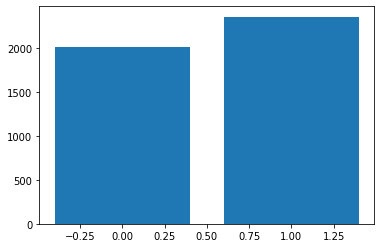

In [25]:
plt.bar(precio_por_cober.index,precio_por_cober['Precio/Tam'] )

# Análisis de clusters

In [26]:
km5 = cluster.KMeans(n_clusters=5)

In [27]:
km5cls = km5.fit(cob_scaled.values)

In [28]:
clusters = cob_precio.assign(cl=km5cls.labels_)
clusters

,Población,% COB OPER,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet,cl
Clave,,,,,,,,,,,,,,,,,,,,
010010001,722250,1,6099.877565,POINT (-102.29611 21.88083),0.937929,0.772303,184123,74.500000,23.600000,10.000000,-1.468581,0.855988,0.620688,0.911782,0.983375,0.424211,0.566453,0.796663,0.298730,3
010010106,1382,1,821.551724,POINT (-102.27444 21.80083),0.918812,0.802460,255,79.500000,36.400000,7.000000,-1.102892,0.815686,0.529412,0.858824,0.980392,0.145098,0.333333,0.745098,0.090196,0
010010120,935,1,527.472577,POINT (-102.29556 21.71750),0.955182,0.760428,217,87.200000,39.200000,6.500000,-1.041144,0.783410,0.493088,0.820276,0.976959,0.064516,0.276498,0.599078,0.055839,0
010010126,509,1,180.000000,POINT (-102.19806 22.00778),0.920213,0.760314,123,88.200000,32.300000,8.700000,-1.214816,0.747967,0.487805,0.894309,0.943089,0.308943,0.349593,0.471545,0.130081,0
010010135,234,1,6341.248721,POINT (-102.31083 21.69944),0.908046,0.841880,47,90.200000,39.900000,6.900000,-0.833872,0.723404,0.574468,0.787234,0.914894,0.085106,0.000000,0.723404,0.055839,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320560163,15,1,6523.809524,POINT (-102.60639 22.76389),0.857143,0.800000,5,100.000000,0.000000,13.300000,-1.673440,0.800000,0.664824,0.800000,1.000000,0.800000,0.800000,1.000000,0.600000,1
320560168,9,1,8057.553957,POINT (-102.56944 22.75361),0.888077,0.740047,2,93.266667,16.133333,10.533333,-0.577800,0.763530,0.592646,0.852137,0.994807,0.495805,0.536205,0.877018,0.449057,1
320560170,22,1,187.500000,POINT (-102.64861 22.75778),1.000000,0.409091,4,95.500000,35.700000,6.400000,0.395876,0.851748,0.750000,0.750000,0.990534,0.000000,0.000000,1.000000,0.000000,0


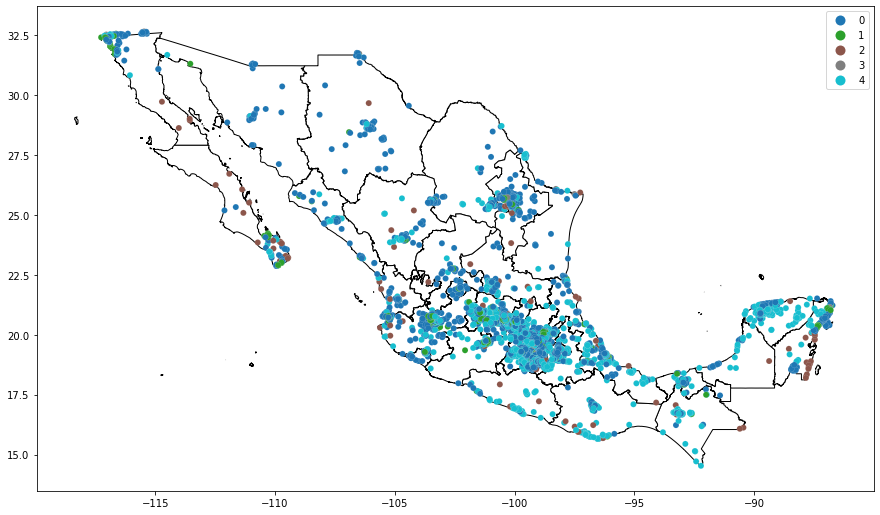

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
mex.plot(ax=ax,color='white',edgecolor='black')
clusters.plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()


In [30]:
clusters.groupby('cl').mean()

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
cl,,,,,,,,,,,,,,,,,,
0,7327.033008,1.0,2212.594973,0.956213,0.644104,1836.385596,78.143823,26.095880,8.112328,-1.039825,0.690628,0.501063,0.811458,0.952401,0.217764,0.297880,0.729018,0.129541
1,11065.177551,1.0,4160.947532,0.971025,0.661950,3002.510204,54.307381,14.375272,12.147925,-1.483699,0.847105,0.809209,0.885136,0.970877,0.670763,0.655411,0.885738,0.563413
2,2301.142857,0.0,2015.450266,0.974294,0.600837,545.373626,78.973993,20.767216,6.506960,-0.390732,0.517322,0.447438,0.614642,0.724469,0.134857,0.140728,0.430485,0.087903
3,724697.830189,1.0,6862.349772,0.952850,0.667080,188459.169811,73.433962,21.384906,10.207547,-1.420584,0.792262,0.529126,0.869190,0.975410,0.447032,0.620020,0.789206,0.352023
4,1199.021418,1.0,1816.068900,0.953790,0.591431,278.393648,87.132373,22.242196,6.207053,-0.263674,0.426910,0.301458,0.713522,0.850620,0.078248,0.130483,0.517539,0.036869


In [31]:
clusters.groupby('cl').count()

,Población,% COB OPER,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
cl,,,,,,,,,,,,,,,,,,,
0,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,490,490,490,490,490,490,490,490,490,490,490,490,490,490,490,490,490,490,490
2,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91
3,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
4,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354


# Regresión lineal

## Precio/m$^2$ como variable dependiente

In [32]:
cob_precio.groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91
1,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563


In [33]:
cob_precio.drop('geometry',axis=1).describe()

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
count,4.654000e+03,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,1.400895e+04,0.980447,2351.463320,0.957383,0.630074,3605.918350,78.211843,23.582864,7.975383,-0.852395,0.628147,0.474706,0.787532,0.920540,0.225858,0.287417,0.678840,0.149980
std,8.924953e+04,0.138473,2609.072223,0.043033,0.165304,23012.745954,20.572271,8.568447,2.153203,0.575738,0.205751,0.219204,0.131207,0.111625,0.205359,0.228088,0.199495,0.190789
min,1.000000e+00,0.000000,149.811015,0.500000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-1.818301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+00,1.000000,666.666667,0.944190,0.540257,2.000000,68.025000,19.100000,6.600000,-1.232724,0.515106,0.323399,0.730613,0.906484,0.083333,0.096084,0.571429,0.016771
50%,1.330000e+02,1.000000,1479.560269,0.964870,0.650520,33.000000,85.166667,23.700000,7.700000,-0.967215,0.660965,0.456088,0.807311,0.953125,0.179775,0.262363,0.706783,0.089947
75%,1.678000e+03,1.000000,3169.346421,0.985101,0.740741,399.250000,93.700000,28.600000,9.000000,-0.616609,0.770323,0.609743,0.869606,0.976851,0.299591,0.431652,0.812795,0.197055
max,1.815786e+06,1.000000,21850.000000,1.000000,2.006423,453752.000000,100.000000,75.000000,16.500000,3.092976,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
X = cob_scaled.drop('Precio/Tam',axis=1).values
y = cob_precio['Precio/Tam'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=cob_scaled['% COB OPER'].values)

In [36]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
coeff_df = pd.DataFrame(regressor.coef_, cob_scaled.drop('Precio/Tam',axis=1).columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Población,-1265.484670
% COB OPER,-47.290956
Empleo,-25.613404
Salud,-101.007474
VIV2,1675.128241
MIG1_R,-233.089841
EDU37_R,67.296203
EDU49_R,-32.480761
IM_2010,367.984032
Lavadora,-35.212860


In [38]:
regressor.intercept_

2382.4530505029784

In [39]:
y_pred = regressor.predict(X_test)

In [40]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1552.5925921374574
Mean Squared Error: 4850976.588760384
Root Mean Squared Error: 2202.493266450634


In [41]:
regressor.score(cob_scaled.drop('Precio/Tam',axis=1), cob_precio['Precio/Tam'])

0.12405765620198894

## % COB OPER como variable dependiente

In [42]:
X = cob_scaled.drop('% COB OPER',axis=1).values
y = cob_precio['% COB OPER'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [44]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
coeff_df = pd.DataFrame(regressor.coef_, cob_scaled.drop('% COB OPER',axis=1).columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Población,0.003793
Precio/Tam,-0.001093
Empleo,-0.006642
Salud,0.004005
VIV2,-0.004995
MIG1_R,0.004378
EDU37_R,0.001918
EDU49_R,0.007251
IM_2010,0.010418
Lavadora,-0.012350


In [46]:
y_pred = regressor.predict(X_test)

In [47]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

In [48]:
df[df['Actual']==0]

,Actual,Predicted
46,0,0.766827
54,0,0.977919
69,0,0.837870
78,0,0.874724
139,0,0.929918
173,0,0.965261
216,0,0.805445
332,0,0.948528
351,0,0.801404
454,0,0.968295


In [49]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.044166930540170436
Mean Squared Error: 0.01675521414667764
Root Mean Squared Error: 0.12944193349404837


In [50]:
y.mean()

0.9804469273743017

# Zonas de interés

## Nuevo León

### Precios

c:\programdata\miniconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


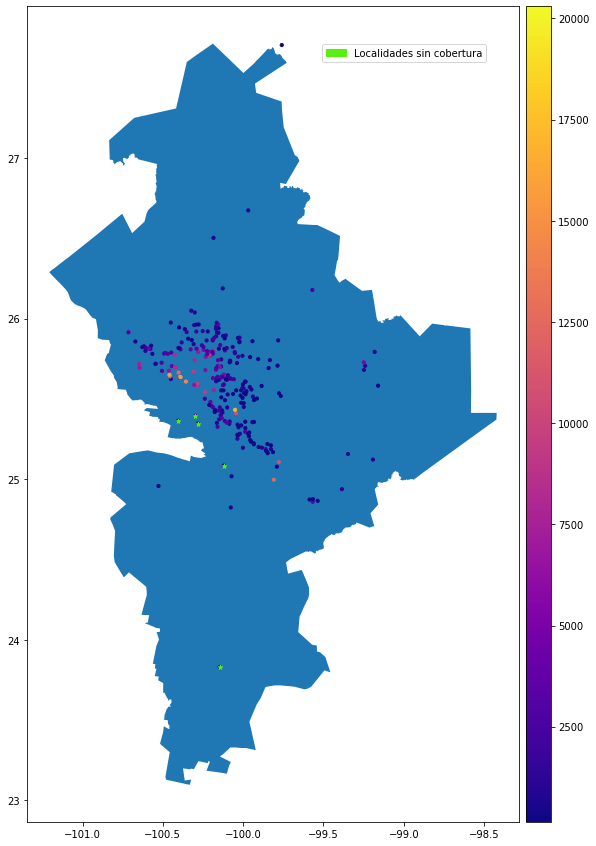

In [51]:
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex[mex['NOMGEO'] == 'Nuevo León'].plot(ax=ax)
cob_precio.loc['19':'20'].plot(ax=ax,markersize=10,column='Precio/Tam', legend=True,cax=cax, cmap='plasma')
cob_precio.loc['19':'20'][(cob_precio['% COB OPER']==0)].plot(ax=ax, markersize=20, color='#58F011',marker='*',legend=True)
red_patch = mpatches.Patch(color='#58F011', label='Localidades sin cobertura')
plt.legend(handles=[red_patch],bbox_to_anchor=(.70,.85),bbox_transform=plt.gcf().transFigure)
#plt.scatter(cob_precio.geometry.x,cob_precio.geometry.y,c=cob_precio['COB OPERAD']=='SI', cmap = cm.RdYlGn)
plt.show()

### Análisis exploratorio

In [52]:
nleon = gpd.GeoDataFrame(pd.merge(cob_scaled.loc['19':'20'],cob_precio['geometry'],how='left', on='Clave'))
corrMatrix = cob_precio.loc['19':'20'].drop('geometry',axis=1).corr()
#cob_

In [53]:
corrMatrix

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
Población,1.000000,0.024094,0.194201,-0.080435,0.055845,0.999785,0.002583,-0.012866,0.227557,-0.154972,0.114857,-0.017580,0.089666,0.053803,0.293672,0.319433,0.027928,0.307299
% COB OPER,0.024094,1.000000,0.076300,-0.077294,-0.036683,0.024028,-0.140873,0.134903,0.176366,-0.104002,0.000140,0.060605,0.044579,0.480308,0.146906,0.063650,0.389569,0.112756
Precio/Tam,0.194201,0.076300,1.000000,-0.121449,0.039078,0.193021,-0.069940,-0.078165,0.285300,-0.099127,0.090147,0.076772,0.143398,0.030818,0.392965,0.359658,0.059802,0.419323
Empleo,-0.080435,-0.077294,-0.121449,1.000000,-0.202954,-0.080053,-0.112624,0.055801,0.021767,-0.064168,0.035494,0.074747,0.107682,0.051184,-0.016708,-0.028183,0.044780,-0.063664
Salud,0.055845,-0.036683,0.039078,-0.202954,1.000000,0.056040,-0.034234,0.260257,0.194368,-0.241275,0.222605,-0.152090,-0.008329,0.156249,0.078790,0.080362,0.134720,0.075694
VIV2,0.999785,0.024028,0.193021,-0.080053,0.056040,1.000000,0.003323,-0.013262,0.226965,-0.154698,0.114509,-0.017152,0.088868,0.053589,0.292469,0.317940,0.027657,0.306069
MIG1_R,0.002583,-0.140873,-0.069940,-0.112624,-0.034234,0.003323,1.000000,-0.090309,-0.248884,0.133420,0.104881,0.240292,-0.088465,-0.124871,-0.002021,0.056561,-0.375344,-0.035303
EDU37_R,-0.012866,0.134903,-0.078165,0.055801,0.260257,-0.013262,-0.090309,1.000000,0.014146,0.032518,-0.244498,-0.305956,-0.201143,0.262068,-0.091826,-0.194371,0.146122,-0.099485
EDU49_R,0.227557,0.176366,0.285300,0.021767,0.194368,0.226965,-0.248884,0.014146,1.000000,-0.643573,0.392085,0.351128,0.444829,0.229891,0.684425,0.519810,0.421263,0.602999
IM_2010,-0.154972,-0.104002,-0.099127,-0.064168,-0.241275,-0.154698,0.133420,0.032518,-0.643573,1.000000,-0.720006,-0.153444,-0.533383,-0.272287,-0.501988,-0.450930,-0.402891,-0.419180


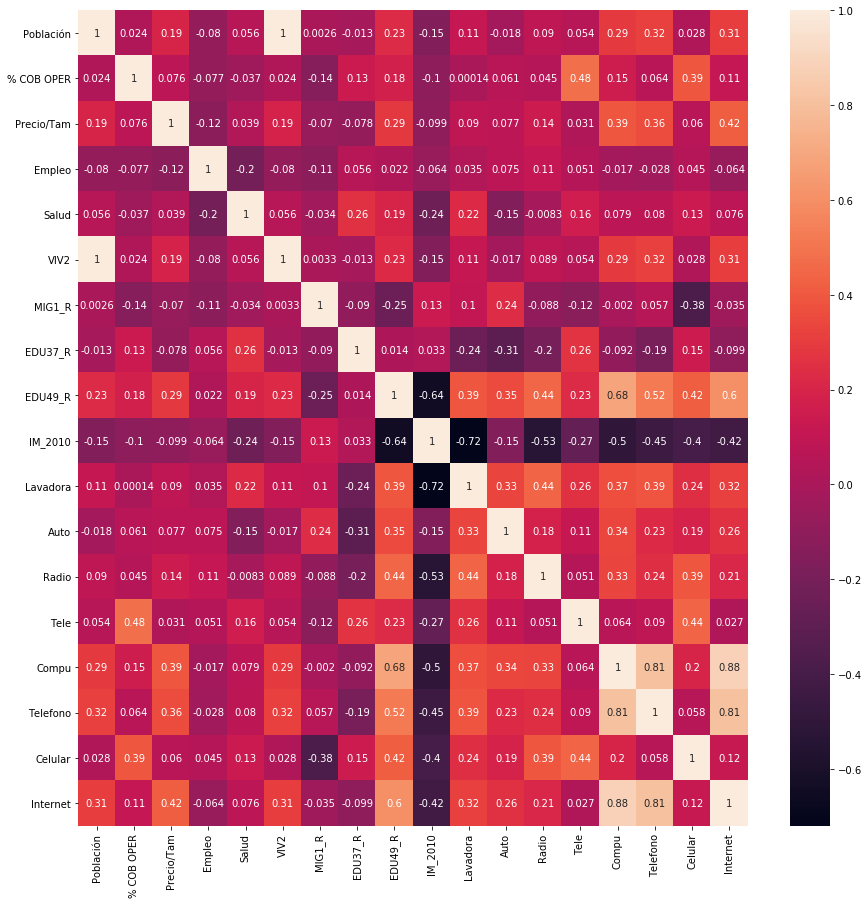

In [54]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)

In [55]:
cob_precio.loc['19':'20'].groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251


In [56]:
precio_por_cober = cob_precio.loc['19':'20'].groupby('% COB OPER').mean()
precio_por_cober

,Población,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,
0,114.400000,597.773408,0.987992,0.760626,38.800000,90.500000,16.786667,5.620000,-0.712511,0.765549,0.532940,0.748914,0.735691,0.036121,0.155831,0.320993,0.018559
1,16796.438247,2431.266046,0.970526,0.729804,4278.370518,75.376228,27.011554,7.795817,-1.055063,0.765705,0.603862,0.785471,0.955550,0.185219,0.249183,0.760601,0.121666


<BarContainer object of 2 artists>

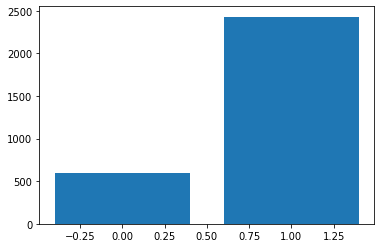

In [57]:
plt.bar(precio_por_cober.index,precio_por_cober['Precio/Tam'] )

### Clusters aglomerativos

In [58]:
wtq = lp.weights.Queen.from_dataframe(nleon)
wtq.n

256

In [59]:
model = cluster.AgglomerativeClustering(linkage='ward',
                                            connectivity=wtq.sparse,
                                            n_clusters=5)
model.fit(nleon.drop('geometry', axis=1))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<256x256 sparse matrix of type '<class 'numpy.float64'>'
	with 1496 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=5)

In [60]:
nleon['cl'] = model.labels_

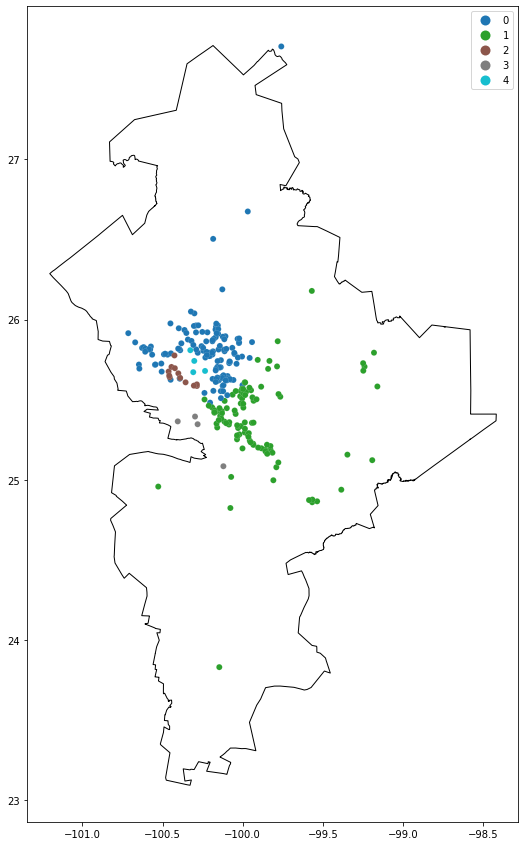

In [61]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Nuevo León')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
nleon.plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

### Clusters

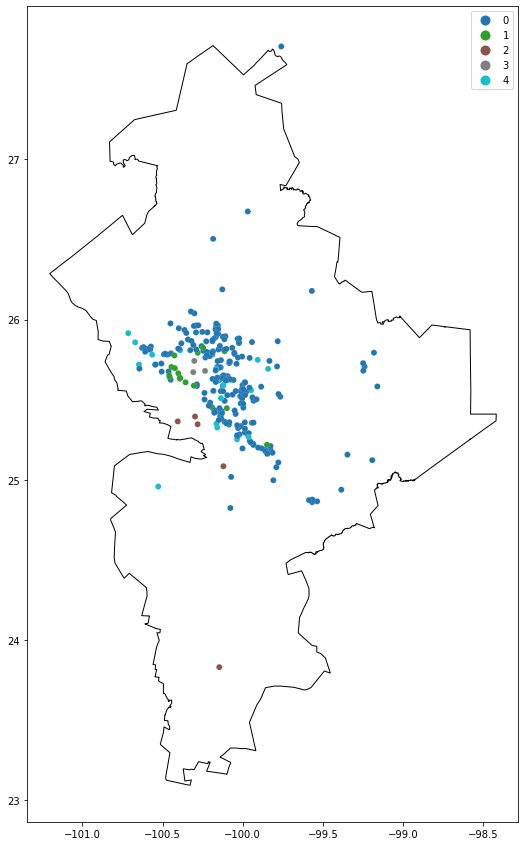

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Nuevo León')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
clusters.loc['19':'20'].plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

## Quintana Roo

### Precios

c:\programdata\miniconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


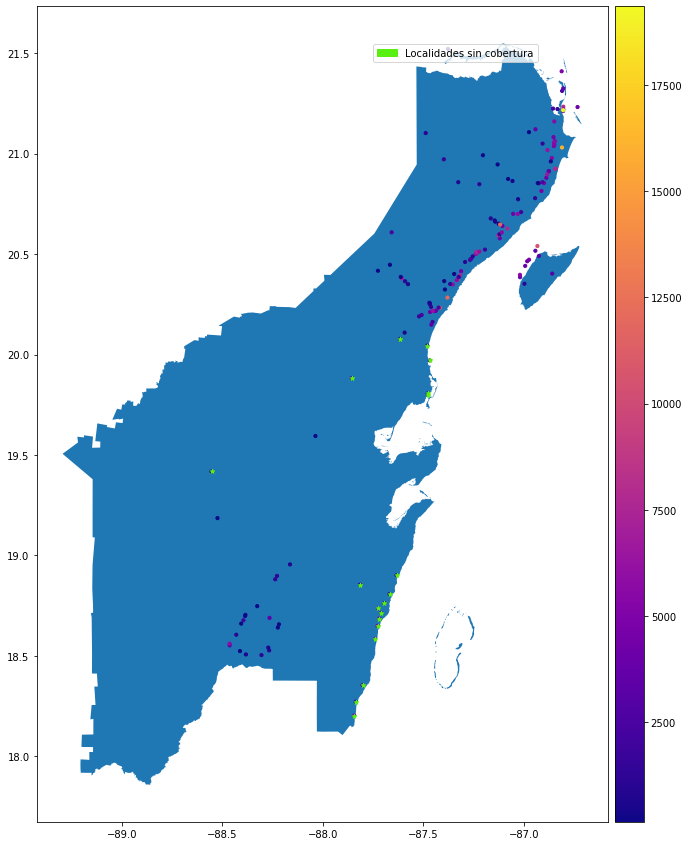

In [63]:
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex[mex['NOMGEO'] == 'Quintana Roo'].plot(ax=ax)
cob_precio.loc['23':'24'].plot(ax=ax,markersize=10,column='Precio/Tam', legend=True,cax=cax, cmap='plasma')
cob_precio.loc['23':'24'][(cob_precio['% COB OPER']==0)].plot(ax=ax, markersize=20, color='#58F011',marker='*',legend=True)
red_patch = mpatches.Patch(color='#58F011', label='Localidades sin cobertura')
plt.legend(handles=[red_patch],bbox_to_anchor=(.70,.85),bbox_transform=plt.gcf().transFigure)
#plt.scatter(cob_precio.geometry.x,cob_precio.geometry.y,c=cob_precio['COB OPERAD']=='SI', cmap = cm.RdYlGn)
plt.show()

### Análisis exploratorio

In [64]:
qroo = gpd.GeoDataFrame(pd.merge(cob_scaled.loc['23':'24'],cob_precio['geometry'],how='left', on='Clave'))
corrMatrix = cob_precio.loc['23':'24'].drop('geometry', axis=1).corr()
#cob_

In [65]:
corrMatrix

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
Población,1.000000,0.049483,0.073893,-0.079602,0.056589,0.999813,0.003369,0.037285,0.063057,-0.076765,0.063366,-0.009359,0.080988,0.073952,0.039613,0.088072,0.056208,0.020239
% COB OPER,0.049483,1.000000,0.103516,-0.147348,0.234256,0.049432,-0.217746,-0.053148,0.193784,-0.360686,0.236853,0.041363,0.150620,0.630441,0.104447,0.189512,0.263760,0.079260
Precio/Tam,0.073893,0.103516,1.000000,-0.001019,-0.081238,0.076260,-0.367143,-0.045795,0.353364,-0.338056,0.150602,0.330166,0.110831,0.233920,0.293813,0.242662,0.375495,0.293291
Empleo,-0.079602,-0.147348,-0.001019,1.000000,-0.199391,-0.080125,0.044813,-0.167053,-0.046009,0.087102,0.072400,0.073957,-0.197284,-0.198765,0.015195,0.067261,-0.136475,0.027574
Salud,0.056589,0.234256,-0.081238,-0.199391,1.000000,0.055740,0.377678,0.118438,-0.080759,-0.001209,-0.025123,-0.117099,0.232942,0.271450,-0.041759,0.149024,-0.333465,-0.078997
VIV2,0.999813,0.049432,0.076260,-0.080125,0.055740,1.000000,0.001528,0.037495,0.063688,-0.077204,0.062389,-0.009664,0.079812,0.073667,0.039698,0.087355,0.056673,0.020216
MIG1_R,0.003369,-0.217746,-0.367143,0.044813,0.377678,0.001528,1.000000,0.350832,-0.646098,0.512027,-0.110225,-0.540140,-0.227162,-0.253645,-0.458843,-0.253743,-0.677004,-0.472923
EDU37_R,0.037285,-0.053148,-0.045795,-0.167053,0.118438,0.037495,0.350832,1.000000,-0.163608,-0.135657,0.094223,-0.399734,-0.160324,0.219510,-0.348306,-0.376934,-0.119914,-0.405960
EDU49_R,0.063057,0.193784,0.353364,-0.046009,-0.080759,0.063688,-0.646098,-0.163608,1.000000,-0.847743,0.425193,0.729165,0.373516,0.555929,0.820081,0.652647,0.742965,0.746670
IM_2010,-0.076765,-0.360686,-0.338056,0.087102,-0.001209,-0.077204,0.512027,-0.135657,-0.847743,1.000000,-0.635853,-0.536640,-0.493189,-0.790755,-0.597744,-0.539143,-0.677990,-0.505683


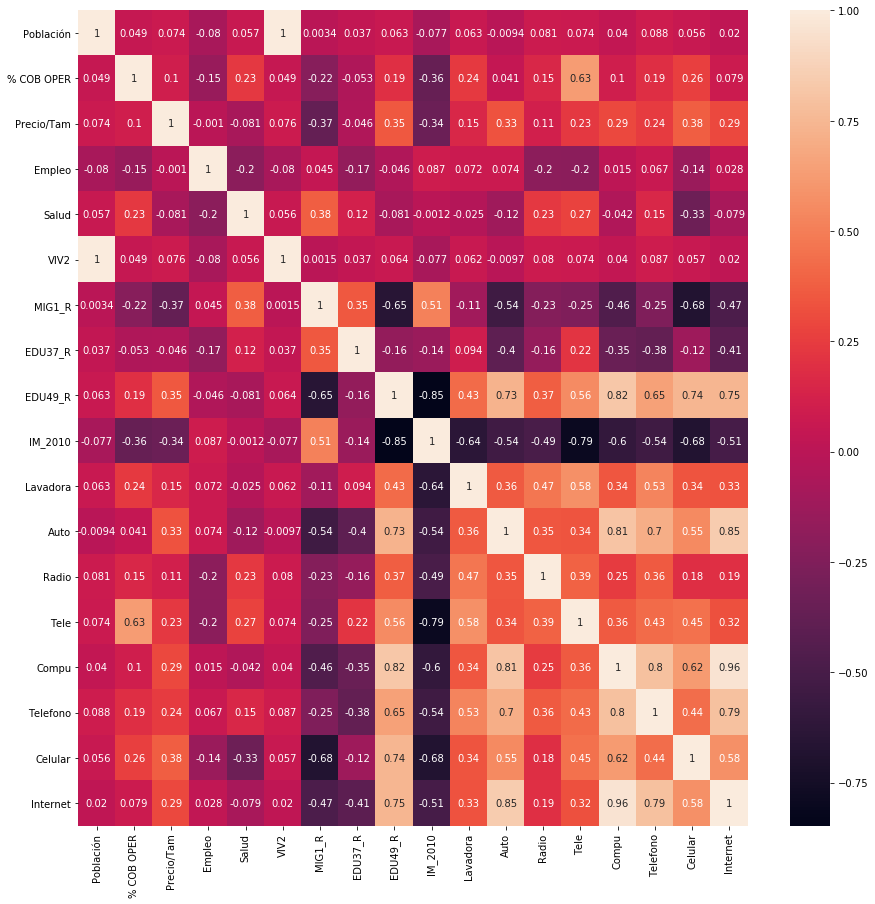

In [66]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)

In [67]:
cob_precio.loc['23':'24'].groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
1,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136


In [68]:
precio_por_cober = cob_precio.loc['23':'24'].groupby('% COB OPER').mean()
precio_por_cober

,Población,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,
0,108.473684,2377.733968,0.984804,0.525809,31.631579,48.975439,25.029825,7.566667,-0.370754,0.556669,0.390739,0.547831,0.577052,0.232410,0.090635,0.630938,0.190401
1,8140.257353,3361.069890,0.976600,0.619452,2281.882353,37.059191,24.098529,8.758333,-0.988317,0.666015,0.412916,0.620858,0.875601,0.300049,0.206592,0.795164,0.246009


<BarContainer object of 2 artists>

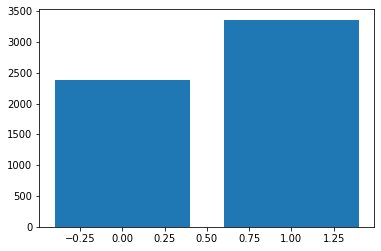

In [69]:
plt.bar(precio_por_cober.index,precio_por_cober['Precio/Tam'] )

### Clusters aglomerativos

In [70]:
wtq = lp.weights.Queen.from_dataframe(qroo)
wtq.n

155

In [71]:
model = cluster.AgglomerativeClustering(linkage='ward',
                                            connectivity=wtq.sparse,
                                            n_clusters=5)
model.fit(qroo.drop('geometry', axis=1))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<155x155 sparse matrix of type '<class 'numpy.float64'>'
	with 862 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=5)

In [72]:
qroo['cl'] = model.labels_

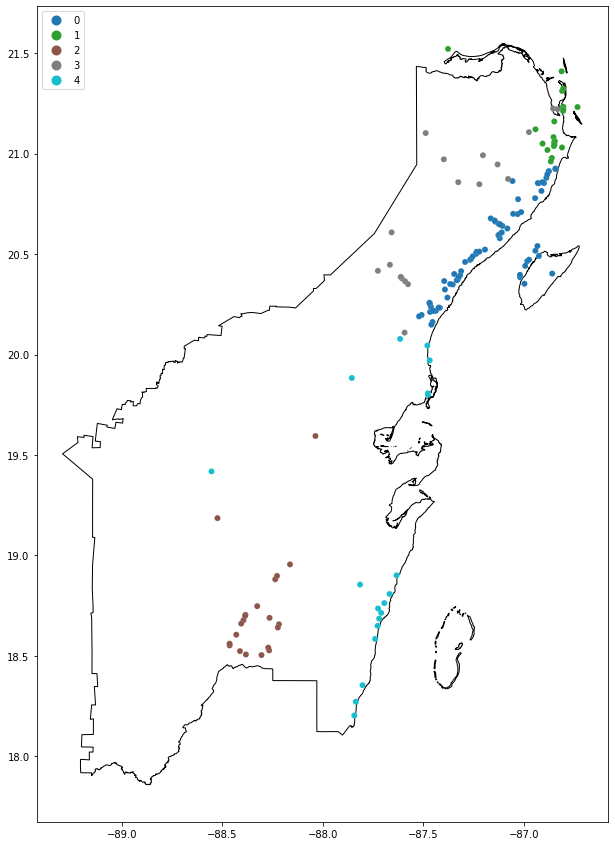

In [73]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Quintana Roo')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
qroo.plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

### Clusters

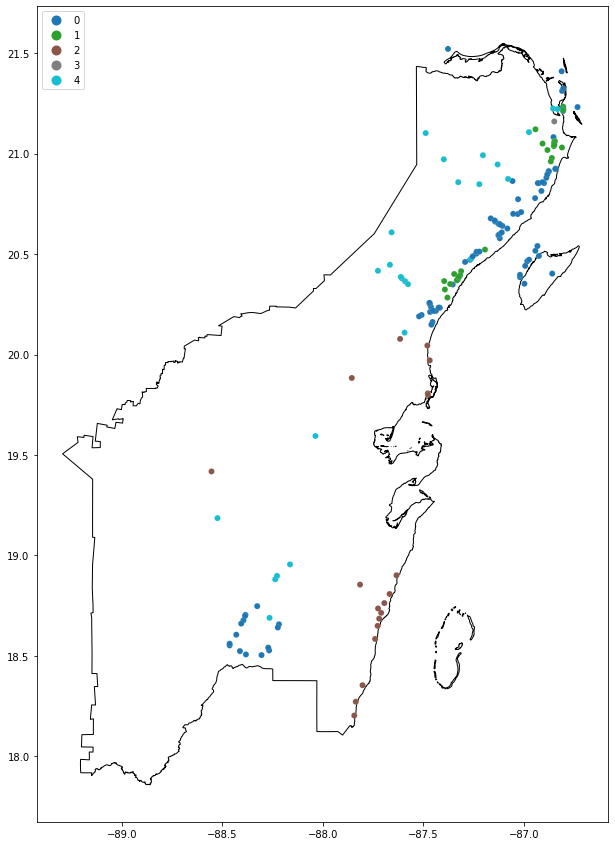

In [74]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Quintana Roo')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
clusters.loc['23':'24'].plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

## Baja California Sur

### Precios

c:\programdata\miniconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


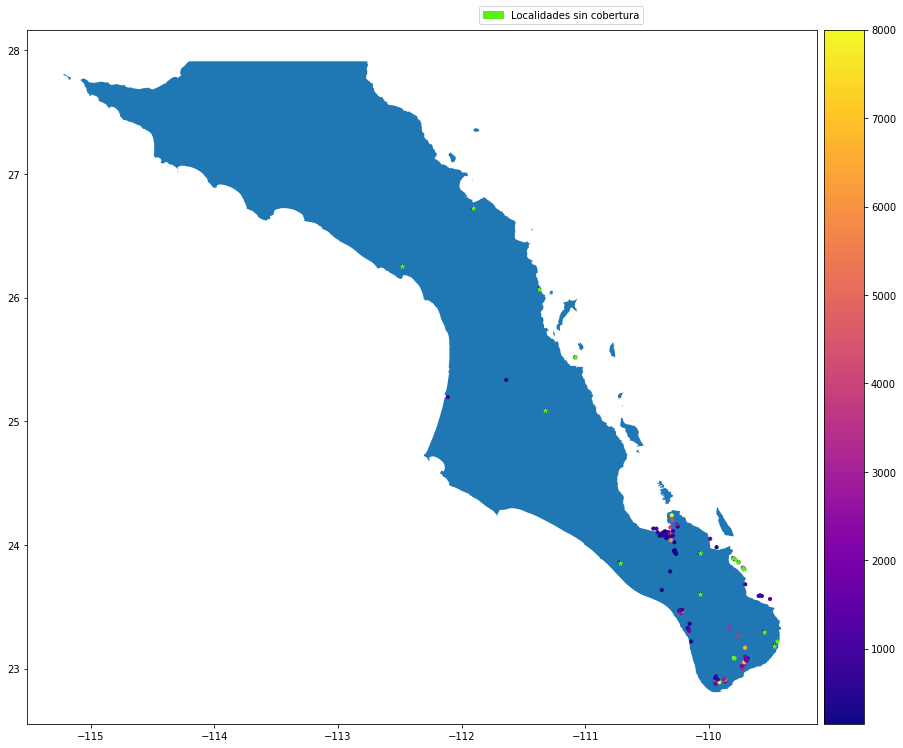

In [75]:
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex[mex['NOMGEO'] == 'Baja California Sur'].plot(ax=ax)
cob_precio.loc['03':'04'].plot(ax=ax,markersize=10,column='Precio/Tam', legend=True,cax=cax, cmap='plasma')
cob_precio.loc['03':'04'][(cob_precio['% COB OPER']==0)].plot(ax=ax, markersize=20, color='#58F011',marker='*',legend=True)
red_patch = mpatches.Patch(color='#58F011', label='Localidades sin cobertura')
plt.legend(handles=[red_patch],bbox_to_anchor=(.70,.85),bbox_transform=plt.gcf().transFigure)
#plt.scatter(cob_precio.geometry.x,cob_precio.geometry.y,c=cob_precio['COB OPERAD']=='SI', cmap = cm.RdYlGn)
plt.show()

### Análisis exploratorio

In [76]:
bcs = gpd.GeoDataFrame(pd.merge(cob_scaled.loc['03':'04'],cob_precio['geometry'],how='left', on='Clave'))
corrMatrix = cob_precio.loc['03':'04'].drop('geometry', axis=1).corr()
#cob_

In [77]:
corrMatrix

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
Población,1.000000,0.077682,0.213440,-0.036118,0.098335,0.999943,-0.030312,-0.017299,0.051997,-0.092357,0.034083,-0.118328,0.013058,0.064876,0.071676,0.100691,0.057826,0.063985
% COB OPER,0.077682,1.000000,0.125646,0.050073,-0.180911,0.076913,-0.336403,-0.054591,0.416501,-0.440434,0.230405,0.037102,0.204317,0.422178,0.382341,0.314343,0.583221,0.327396
Precio/Tam,0.213440,0.125646,1.000000,-0.203784,0.149094,0.211414,-0.118379,-0.161860,0.285641,-0.297033,0.272645,0.098553,0.126996,0.185042,0.405529,0.209341,0.229148,0.397371
Empleo,-0.036118,0.050073,-0.203784,1.000000,-0.291291,-0.035432,-0.358930,-0.274161,0.215688,0.171926,-0.189556,0.346320,-0.024787,-0.195313,0.103140,0.286075,-0.163193,0.145530
Salud,0.098335,-0.180911,0.149094,-0.291291,1.000000,0.097754,0.367612,0.028142,-0.069003,-0.153965,0.226811,-0.259387,0.016102,0.077827,0.130472,0.027062,-0.131120,0.137860
VIV2,0.999943,0.076913,0.211414,-0.035432,0.097754,1.000000,-0.028848,-0.017855,0.052488,-0.092334,0.034809,-0.115285,0.014901,0.064499,0.072054,0.101030,0.057325,0.064336
MIG1_R,-0.030312,-0.336403,-0.118379,-0.358930,0.367612,-0.028848,1.000000,0.323775,-0.602721,0.291163,-0.198399,-0.381287,-0.351776,-0.100888,-0.506488,-0.564638,-0.253940,-0.511760
EDU37_R,-0.017299,-0.054591,-0.161860,-0.274161,0.028142,-0.017855,0.323775,1.000000,-0.380602,-0.069025,0.107468,-0.336987,-0.035728,0.254512,-0.375480,-0.461188,0.019658,-0.344498
EDU49_R,0.051997,0.416501,0.285641,0.215688,-0.069003,0.052488,-0.602721,-0.380602,1.000000,-0.727591,0.588644,0.645050,0.529663,0.486988,0.870234,0.852872,0.471732,0.819906
IM_2010,-0.092357,-0.440434,-0.297033,0.171926,-0.153965,-0.092334,0.291163,-0.069025,-0.727591,1.000000,-0.846483,-0.341156,-0.538982,-0.730482,-0.752618,-0.628506,-0.623552,-0.654145


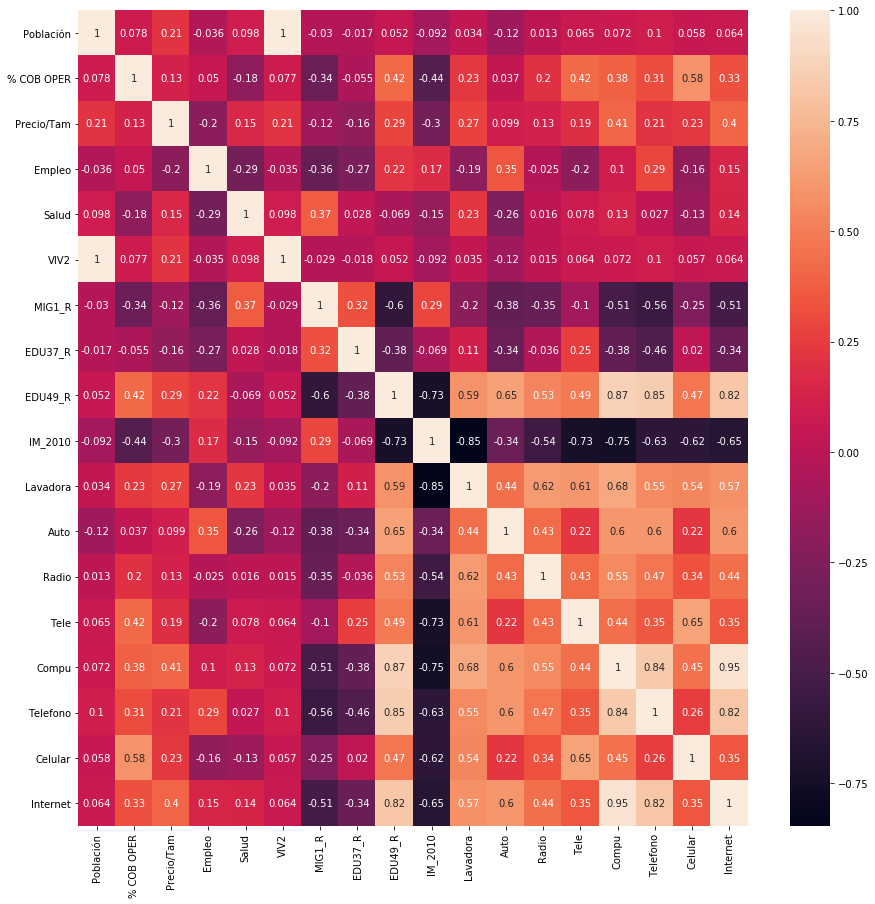

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)

In [79]:
cob_precio.loc['03':'04'].groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
1,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79


In [80]:
precio_por_cober = cob_precio.loc['03':'04'].groupby('% COB OPER').mean()
precio_por_cober

,Población,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,
0,59.882353,1270.851708,0.953337,0.720066,15.176471,78.541176,23.006863,7.305882,-0.613017,0.583105,0.785159,0.691432,0.792175,0.155745,0.114394,0.551977,0.100350
1,4907.873418,1915.048757,0.959354,0.636743,1369.126582,58.406118,21.578270,9.952743,-1.207943,0.704758,0.795327,0.764281,0.940798,0.423891,0.348849,0.882973,0.342103


<BarContainer object of 2 artists>

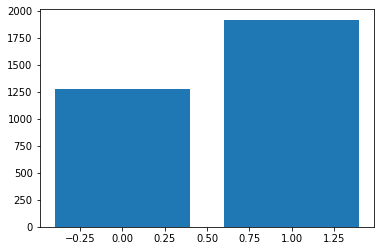

In [81]:
plt.bar(precio_por_cober.index,precio_por_cober['Precio/Tam'] )

### Clusters aglomerativos

In [82]:
bcs = gpd.GeoDataFrame(pd.merge(cob_scaled.loc['03':'04'],cob_precio['geometry'],how='left', on='Clave'))
wtq = lp.weights.Queen.from_dataframe(bcs)
wtq.n

96

In [83]:
model = cluster.AgglomerativeClustering(linkage='ward',
                                            connectivity=wtq.sparse,
                                            n_clusters=5)
model.fit(bcs.drop('geometry', axis=1))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<96x96 sparse matrix of type '<class 'numpy.float64'>'
	with 526 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=5)

In [84]:
bcs['cl'] = model.labels_

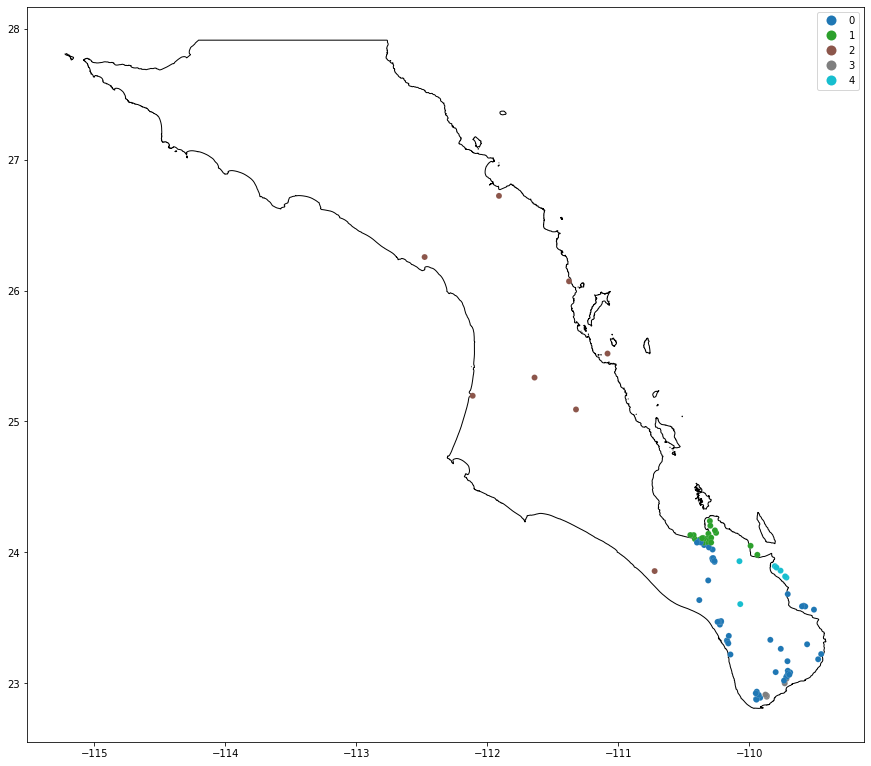

In [85]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Baja California Sur')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
bcs.plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

### Clusters

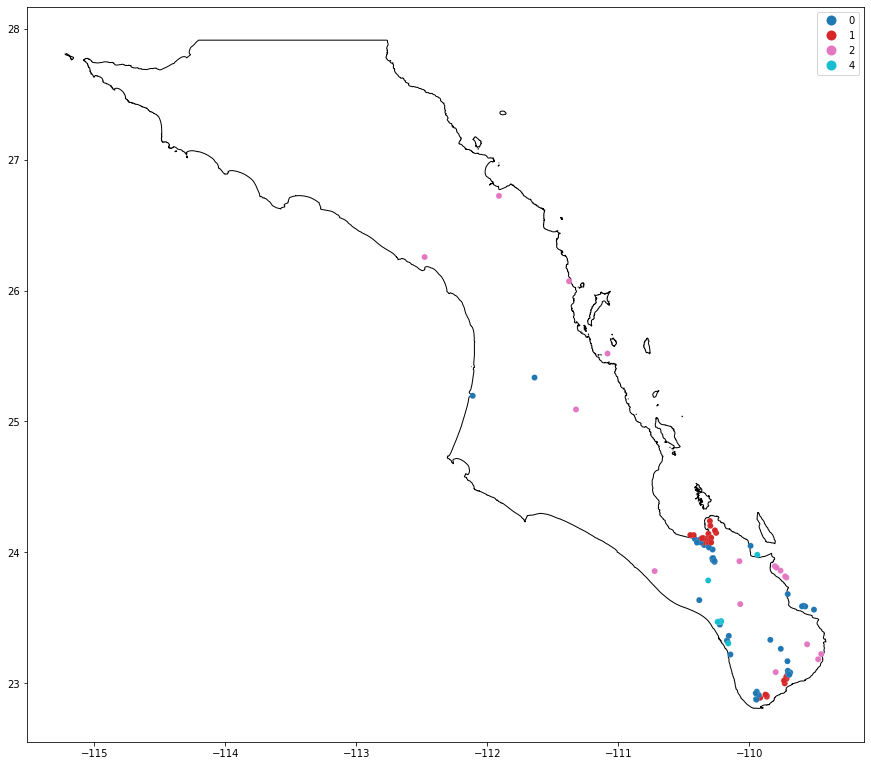

In [86]:
fig, ax = plt.subplots(figsize=(15,15))
mex[(mex['NOMGEO'] == 'Baja California Sur')].plot(ax=ax,color='white',edgecolor='black')
#xmin,ymin,xmax,ymax = mex1[(mex1['NOMGEO'] == 'México')].total_bounds
#mex.plot(ax=ax,color='white',edgecolor='black')
clusters.loc['03':'04'].plot(column='cl', categorical=True, legend=True, 
         linewidth=0.1, edgecolor='white', ax=ax)

plt.show()

# Pruebas

In [87]:
cob_precio.groupby('% COB OPER').count()

,Población,Precio/Tam,geometry,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
% COB OPER,,,,,,,,,,,,,,,,,,
0,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91
1,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563


In [88]:
cob_precio.drop('geometry',axis=1).describe()

,Población,% COB OPER,Precio/Tam,Empleo,Salud,VIV2,MIG1_R,EDU37_R,EDU49_R,IM_2010,Lavadora,Auto,Radio,Tele,Compu,Telefono,Celular,Internet
count,4.654000e+03,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,1.400895e+04,0.980447,2351.463320,0.957383,0.630074,3605.918350,78.211843,23.582864,7.975383,-0.852395,0.628147,0.474706,0.787532,0.920540,0.225858,0.287417,0.678840,0.149980
std,8.924953e+04,0.138473,2609.072223,0.043033,0.165304,23012.745954,20.572271,8.568447,2.153203,0.575738,0.205751,0.219204,0.131207,0.111625,0.205359,0.228088,0.199495,0.190789
min,1.000000e+00,0.000000,149.811015,0.500000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-1.818301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+00,1.000000,666.666667,0.944190,0.540257,2.000000,68.025000,19.100000,6.600000,-1.232724,0.515106,0.323399,0.730613,0.906484,0.083333,0.096084,0.571429,0.016771
50%,1.330000e+02,1.000000,1479.560269,0.964870,0.650520,33.000000,85.166667,23.700000,7.700000,-0.967215,0.660965,0.456088,0.807311,0.953125,0.179775,0.262363,0.706783,0.089947
75%,1.678000e+03,1.000000,3169.346421,0.985101,0.740741,399.250000,93.700000,28.600000,9.000000,-0.616609,0.770323,0.609743,0.869606,0.976851,0.299591,0.431652,0.812795,0.197055
max,1.815786e+06,1.000000,21850.000000,1.000000,2.006423,453752.000000,100.000000,75.000000,16.500000,3.092976,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
? pd.concat

In [91]:
regresion = pd.concat(cob_scaled.drop('Precio/Tam', axis=1),cob_precio['Precio/Tam'], axis=1)
regresion

TypeError: concat() got multiple values for argument 'axis'

In [34]:
X = cob_scaled.drop('Precio/Tam',axis=1).values
y = cob_precio['Precio/Tam'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=cob_scaled['% COB OPER'].values)

In [36]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
coeff_df = pd.DataFrame(regressor.coef_, cob_scaled.drop('Precio/Tam',axis=1).columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Población,-1265.484670
% COB OPER,-47.290956
Empleo,-25.613404
Salud,-101.007474
VIV2,1675.128241
MIG1_R,-233.089841
EDU37_R,67.296203
EDU49_R,-32.480761
IM_2010,367.984032
Lavadora,-35.212860


In [38]:
regressor.intercept_

2382.4530505029784

In [39]:
y_pred = regressor.predict(X_test)

In [40]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1552.5925921374574
Mean Squared Error: 4850976.588760384
Root Mean Squared Error: 2202.493266450634


In [41]:
regressor.score(cob_scaled.drop('Precio/Tam',axis=1), cob_precio['Precio/Tam'])

0.12405765620198894

## % COB OPER como variable dependiente

In [42]:
X = cob_scaled.drop('% COB OPER',axis=1).values
y = cob_precio['% COB OPER'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [44]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
coeff_df = pd.DataFrame(regressor.coef_, cob_scaled.drop('% COB OPER',axis=1).columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Población,0.003793
Precio/Tam,-0.001093
Empleo,-0.006642
Salud,0.004005
VIV2,-0.004995
MIG1_R,0.004378
EDU37_R,0.001918
EDU49_R,0.007251
IM_2010,0.010418
Lavadora,-0.012350


In [46]:
y_pred = regressor.predict(X_test)

In [47]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

In [48]:
df[df['Actual']==0]

,Actual,Predicted
46,0,0.766827
54,0,0.977919
69,0,0.837870
78,0,0.874724
139,0,0.929918
173,0,0.965261
216,0,0.805445
332,0,0.948528
351,0,0.801404
454,0,0.968295


In [49]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.044166930540170436
Mean Squared Error: 0.01675521414667764
Root Mean Squared Error: 0.12944193349404837


In [50]:
y.mean()

0.9804469273743017